In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from brian2 import *
import matplotlib.pyplot as plt

In [3]:
def plot_stuff(M_spikes, MV, Mge, Mgi, name='', observation_list=[0]):
    figure(figsize=(5,5))
    #plotting spikes of cells on raster plot.
    subplot(2,2,1)
    title(f'{name} spikes')
    plot(M_spikes.t/ms, M_spikes.i, '.k')
    
    #observation_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    observation_list = observation_list

    #plotting voltage
    subplot(2,2,2)
    title('V')
    for i in observation_list:
        plot(MV.t/ms, MV.Vm[i])

    subplot(2,2,3)
    title('ge')
    for i in observation_list:
        plot(Mge.t/ms, Mge.ge[i])

    subplot(2,2,4)
    title('gi')
    for i in observation_list:
        plot(Mgi.t/ms, Mgi.gi[i])

    show()
    
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(14, 4))
    
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
    #subplot(133)
    #scatter(S.x_pre/um, S.x_post/um, S.w*20)
    #xlabel('Source neuron position (um)')
    #ylabel('Target neuron position (um)')
    
def plot_connectivity_matrix(W_matrix, title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.imshow(data)
    #ax.set_aspect('equal')
    s = ax.pcolor(W_matrix, vmin=-1, vmax=1)
    ax.set_title(title)
    ax.set_aspect('equal')
    cax = fig.add_axes([1.02, 0.05, 0.02, 0.9])
    #m = matplotlib.cm.ScalarMappable(cmap='viridis')
    #fig.colorbar(m, cbax, ticks=[-1, -0.5, 0, 0.5, 1])    
    #fig.colorbar(W_matrix)
    fig.colorbar(s, ax=ax, cax=cax)
    plt.show()

In [4]:
# Constants
N_TL2 = 16
N_CL1 = 16
N_TB1 = 8
N_TN = 2
N_CPU4 = 16
N_CPU1A = 14
N_CPU1B = 2
N_CPU1 = N_CPU1A + N_CPU1B
N_PONTINE = 2

In [5]:
# Neuron specification
eqs = '''
      dVm/dt  = ((El - Vm) + Isyn) / taum : volt
      Isyn = ge - gi : volt
      dge/dt = -ge/taue : volt
      dgi/dt = -gi/taui : volt
      '''
threshold_eqs = 'Vm >= Vt'
reset_eqs = 'Vm = Vr'

G_TL2 = NeuronGroup(N=N_TL2, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
G_CL1 = NeuronGroup(N=N_CL1, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
G_TB1 = NeuronGroup(N=N_TB1, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
G_TN = NeuronGroup(N=N_TN, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
G_CPU4 = NeuronGroup(N=N_CPU4, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
G_CPU1A = NeuronGroup(N=N_CPU1A, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
G_CPU1B = NeuronGroup(N=N_CPU1B, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
G_PONTINE = NeuronGroup(N=N_PONTINE, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')

In [6]:
def gen_tb_tb_weights(weight=1.):
    """
    Weight matrix to map inhibitory connections from TB1 to other neurons
    
    from Thomas Stone's path-integration repo
    """
    W = np.zeros([N_TB1, N_TB1])
    sinusoid = -(np.cos(np.linspace(0, 2*np.pi, N_TB1, endpoint=False)) - 1)/2
    for i in range(N_TB1):
        values = np.roll(sinusoid, i)
        W[i, :] = values
    return weight * W

W_CL1_TB1 = np.tile(np.eye(N_TB1), 2)
W_TB1_TB1 = gen_tb_tb_weights()
W_TB1_CPU1a = np.tile(np.eye(N_TB1), (2, 1))[1:N_CPU1A+1, :]
W_TB1_CPU1b = np.array([[0, 0, 0, 0, 0, 0, 0, 1],
                             [1, 0, 0, 0, 0, 0, 0, 0]])
W_TB1_CPU4 = np.tile(np.eye(N_TB1), (2, 1))
W_TN_CPU4 = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
]).T
W_CPU4_CPU1a = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
])
W_CPU4_CPU1b = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #8
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], #9
])
W_PONTINE_CPU1a = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], #2
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #15
])
W_PONTINE_CPU1b = np.array([
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #8
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], #9
])
W_CPU4_PONTINE = np.eye(N_CPU4)

# Not sure about these
W_CPU1a_motor = np.array([
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
])
W_CPU1b_motor = np.array([[0, 1],
                          [1, 0]])

In [7]:
_plot = False
if _plot:
    plot_connectivity_matrix(W_CL1_TB1, title='W_CL1_TB1')
    plot_connectivity_matrix(W_TB1_TB1, title='W_TB1_TB1')
    plot_connectivity_matrix(W_TB1_CPU1a, title='W_TB1_CPU1a')
    plot_connectivity_matrix(W_TB1_CPU1b, title='W_TB1_CPU1b')
    plot_connectivity_matrix(W_TB1_CPU4, title='W_TB1_CPU4')
    plot_connectivity_matrix(W_TN_CPU4, title='W_TN_CPU4')
    plot_connectivity_matrix(W_CPU4_CPU1a, title='W_CPU4_CPU1a')
    plot_connectivity_matrix(W_CPU4_CPU1b, title='W_CPU4_CPU1b')
    plot_connectivity_matrix(W_CPU1a_motor, title='W_CPU1a_motor')
    plot_connectivity_matrix(W_CPU1b_motor, title='W_CPU1b_motor')
    plot_connectivity_matrix(W_PONTINE_CPU1a, title='W_PONTINE_CPU1a')
    plot_connectivity_matrix(W_PONTINE_CPU1b, title='W_PONTINE_CPU1b')
    plot_connectivity_matrix(W_CPU4_PONTINE, title='W_CPU4_PONTINE')

In [8]:
def connect_synapses(G_source, G_target, W_matrix, synapses_eqs='w : 1', _plot=False):
    # Connectivity matrix has sources on the rows and targets
    # on the columns whereas Brian2 expects the opposite
    # So you need to transpose it!
    sources, targets = W_matrix.T.nonzero()
    print(sources, targets)
    synapses = Synapses(G_source, G_target, model=synapses_eqs)
    synapses.connect(i=sources, j=targets)
    synapses.w = W_matrix.T[sources, targets]

    if _plot:
        visualise_connectivity(synapses)
        
    return synapses
        
def reconstruct_weight_matrix(G_source, G_target, synapses):
    W = np.full((len(G_source), len(G_target)), 0)
    # Insert the values from the Synapses object
    W[synapses.i[:], synapses.j[:]] = synapses.w[:]
    # Connectivity matrix has sources on the rows and targets
    # on the columns whereas Brian2 expects the opposite
    # So you need to transpose it!
    return W.T

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7]


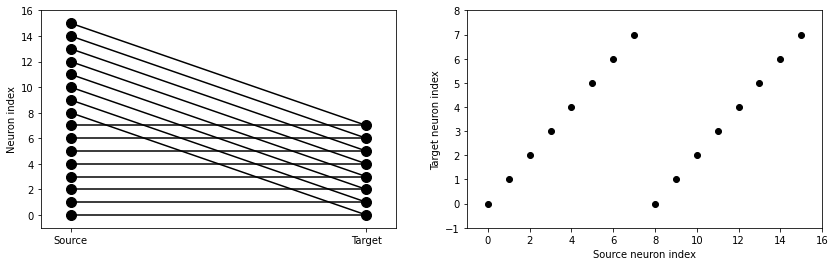

In [9]:
synapses = connect_synapses(G_CL1, G_TB1, W_CL1_TB1, _plot=True)

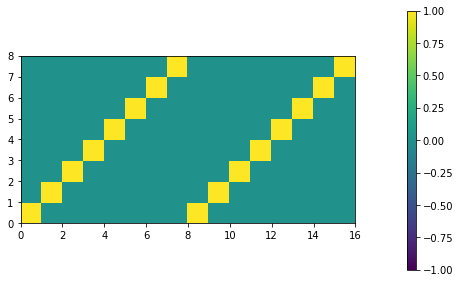

In [10]:
W_temp = reconstruct_weight_matrix(G_CL1, G_TB1, synapses)
plot_connectivity_matrix(W_temp)